In [1]:
"""
-*- coding: utf-8 -*- Created on Fri 21 2020
@author: Thiago Pinho
@colaborators: Thiago Russo, Emmanuel Perotto, Gabriel Vasconcelos
"""


from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
import spacy
from spacy.lang.pt import Portuguese
from spacy.lang.pt.stop_words import STOP_WORDS
from unidecode import unidecode
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from string import punctuation
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from preprocessing import generate_freq_dist_plot, generate_wordcloud
import plotly.express as px
import plotly.graph_objects as go


## Constants
For better code management, the constants used in this notebook will be listed bellow.

In [2]:
VECTOR_MODEL_NAME = "pt_core_news_sm"
RELATIVE_PATH_TO_FOLDER = "./assets/datasets/"
DATA_FILENAME = "Feeds_Label"
NLP_SPACY = spacy.load(VECTOR_MODEL_NAME)
TARGET_VARIABLE = "LABEL_TRAIN"
POSSIBLE_TEXT_VARIABLES = ["CONTENT", "TITLE"]

## Load raw data and analyse it's structure and content

We'll have a first look at the raw data and analyse it's structure so we can fix missing values(By dropping or artificially inserting then). We can encode or adjust categorical data if needed, fix column names and also drop unnused colummns.

In [146]:
"""  load the dataset """
relative_path_file = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + ".csv"
df_ribon_news = pd.read_csv(relative_path_file)
print("Data info:")
df_ribon_news.info()

df_categories1 = df_ribon_news.groupby('Label_Train')['id'].count().reset_index().rename(columns={'id' : 'count'})

fig = px.bar(df_categories1, 
             x='Label_Train', 
             y='count', 
             text='count',
             labels={'Label_Train': 'Categorias de notícias',
                     'count': 'Número de notícias'
             },
             title='Distribuição inicial de categorias de notícias'
            )
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(xaxis_tickangle=45)
fig.show()

df_ribon_news.head()

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           888 non-null    int64 
 1   pick_count   888 non-null    int64 
 2   content      886 non-null    object
 3   title        888 non-null    object
 4   Label_Train  888 non-null    object
dtypes: int64(2), object(3)
memory usage: 34.8+ KB


id  pick_count                                            content  \
0  11           0  A forte ligação dos cães com o ser humano desp...   
1  12           0  Os chamados muros da gentileza estão promovend...   
2   9           0  Alguns de nós sabem a sorte que é ter um irmão...   
3   6           0               Temos muito o que aprender com elas.   
4   1           0  Esqueça o que te disseram sobre a zona de conf...   

                                               title    Label_Train  
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        Animais  
1  Muros da gentileza ajudam desabrigados e famíl...  Solidariedade  
2  20 fotos maravilhosas mostrando a alegria de t...        Familia  
3  13 razões pelas quais crianças são bem mais es...       Criancas  
4  Ex-executiva fala sobre vida sem propósito - I...      Proposito

### Results
Based on the previous step it's possible to notice two things:

1) First is that there is different casing to the same label in the labels column 

2) The categories are not all in the same case either which could lead to later confusion on the real number of categories the model should classify.

So we will fix by making: 

1) All **column names** will be **lowercase**

2) All **target categories** will also be **lowercase**

In [147]:
"""  Preprocessing the dataset names and values """
df_ribon_news.columns = map(lambda x: str(x).upper(), df_ribon_news.columns)
""" Converting all labels in TARGET_VARIABLE to uppercase """
df_ribon_news[TARGET_VARIABLE] = df_ribon_news[TARGET_VARIABLE].str.upper()

print("Column names are now: ", df_ribon_news.columns.to_list())

df_categories2 = df_ribon_news.groupby('LABEL_TRAIN')['ID'].count().reset_index().rename(columns={'ID' : 'COUNT'})

fig = px.bar(df_categories2, 
             x='LABEL_TRAIN', 
             y='COUNT', 
             text='COUNT',
             labels={'LABEL_TRAIN': 'Categorias de notícias',
                     'COUNT': 'Número de notícias'
             },
             title='Distribuição de categorias de notícias pós uniformização'
            )

fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(xaxis_tickangle=45)
fig.show()

df_ribon_news.head()

Column names are now:  ['ID', 'PICK_COUNT', 'CONTENT', 'TITLE', 'LABEL_TRAIN']


ID  PICK_COUNT                                            CONTENT  \
0  11           0  A forte ligação dos cães com o ser humano desp...   
1  12           0  Os chamados muros da gentileza estão promovend...   
2   9           0  Alguns de nós sabem a sorte que é ter um irmão...   
3   6           0               Temos muito o que aprender com elas.   
4   1           0  Esqueça o que te disseram sobre a zona de conf...   

                                               TITLE    LABEL_TRAIN  
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        ANIMAIS  
1  Muros da gentileza ajudam desabrigados e famíl...  SOLIDARIEDADE  
2  20 fotos maravilhosas mostrando a alegria de t...        FAMILIA  
3  13 razões pelas quais crianças são bem mais es...       CRIANCAS  
4  Ex-executiva fala sobre vida sem propósito - I...      PROPOSITO

### Storing partial progress
One of the advantages of jupyter notebook is the possibility of only repeating parts of the code when there is need for it. So let's store our partial progress for more stability and less rework.

In [5]:
"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + "_treated.xlsx"

In [6]:
"""  Convert the dataframe to an xlsx file """
df_ribon_news.to_excel(excel_filename)

print("Stored tread dataset on ", excel_filename)

Stored tread dataset on  ./assets/datasets/Feeds_Label_treated.xlsx


## Load and analyse treated data
Now we have treated some structural characteristics of the data and some details, let's analyse the data.

In [7]:
"""  Load the data for stability """
df_ribon_news_treated = pd.read_excel(excel_filename, index_col=0)
df_ribon_news_treated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 887
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           888 non-null    int64 
 1   PICK_COUNT   888 non-null    int64 
 2   CONTENT      886 non-null    object
 3   TITLE        888 non-null    object
 4   LABEL_TRAIN  888 non-null    object
dtypes: int64(2), object(3)
memory usage: 41.6+ KB


### Choosing text data and dropping unwanted variables
Not all columns available in data will be useful for the label classification.

In [8]:
""" In the previous results, we could that are two text variables besides the target: CONTENT and TITLE.
There's also the numeric variable pick_count which is unrelated to label, so let's add it to a unwanted list """
unwanted_columns = set(['PICK_COUNT', 'ID'])

""" As CONTENT is empty in two cases let's compare it to title which is not empty in any case """
compared_columns = set(['CONTENT', 'TITLE'])
columns_stats = []
columns_series = []
for column in compared_columns:
    column_series = df_ribon_news_treated[column]
    columns_stats.append((column_series.str.len().mean(), column_series.str.len().std()))
    columns_series.append(column_series)

for column, stats in zip(compared_columns, columns_stats):
    mean, std = stats
    mean = str(int(mean))
    std = str(int(std))
    print(
        "Column " + column + " mean length was " + mean + " and standard deviation was " + std)


Column TITLE mean length was 70 and standard deviation was 16
Column CONTENT mean length was 551 and standard deviation was 289


### Results
The variable CONTENT appears to have more data and could bring better results. But as two rows have this column empty we would have to drop those. One way around it is to oversample the data by using both as text variables.

In [9]:
unwanted_columns.union(compared_columns)
wanted_columns = set(df_ribon_news_treated.columns).intersection(unwanted_columns)
df_preprocessed_data = pd.DataFrame(columns=[TARGET_VARIABLE, "TEXT_VARIABLE"])
for column in compared_columns:
    df_labels_texts_variables = df_ribon_news_treated[[TARGET_VARIABLE, column]]
    df_labels_texts_variables = df_labels_texts_variables.rename(columns={column:"TEXT_VARIABLE"})
    df_preprocessed_data = df_preprocessed_data.append(df_labels_texts_variables, ignore_index=True)

print(df_preprocessed_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LABEL_TRAIN    1776 non-null   object
 1   TEXT_VARIABLE  1774 non-null   object
dtypes: object(2)
memory usage: 27.9+ KB
None


### Dealing with missing values
As there are some samples that are empty, they'll not be useful to train or to validate the model. 
Let's drop them

In [10]:
df_preprocessed_data = df_preprocessed_data.dropna()
print(df_preprocessed_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1774 entries, 0 to 1775
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LABEL_TRAIN    1774 non-null   object
 1   TEXT_VARIABLE  1774 non-null   object
dtypes: object(2)
memory usage: 41.6+ KB
None


### Label distribution, oversampling and undersampling
One important step is to analyse how the target categories are distributed. That's useful so we can better partition our data, maybe apply some over or undersampling if it's necessary.

In [148]:
"""  Let"s see how the labels are distributed """
data_labels_count = df_preprocessed_data[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
average_samples_per_label = data_labels_count.mean()
standard_deviation_for_labels = data_labels_count.std()
print(
    "Mean number of samples for the target variable is: ",
    average_samples_per_label)
print(
    "Standard deviation number of samples for the target variable is: ",
    standard_deviation_for_labels)

''' Numerical analysis
    One way to analyse the frequency of certain labels is to notice with
    they're too afar from the other labels frequencies average. Let's use
    standard deviation to check it'''
def is_it_further_than_std_deviations( value ):
    is_too_much = value > average_samples_per_label + standard_deviation_for_labels
    is_too_little = value < average_samples_per_label - standard_deviation_for_labels
    if is_too_much or is_too_little:
        message = "Warning"
    else:
        message = "Okay"

    return message

for i in tqdm(range(0, len(data_labels), 2)):
    even_indexed_label = data_labels[i]
    odd_indexed_label = data_labels[i+1]

    print("{0:20}  {1:10} {2:15} {3:20} {4:10} {5:10}".format(
        even_indexed_label, data_labels_count[even_indexed_label], is_it_further_than_std_deviations(data_labels_count[even_indexed_label]),
        odd_indexed_label, data_labels_count[odd_indexed_label], is_it_further_than_std_deviations(data_labels_count[odd_indexed_label])))

''' Visual plotting'''
df_categories3 = df_preprocessed_data.groupby('LABEL_TRAIN').count().reset_index().rename(columns={'TEXT_VARIABLE' : 'COUNT'})

fig = px.bar(df_categories3, 
             x='LABEL_TRAIN', 
             y='COUNT', 
             text='COUNT',
             labels={'LABEL_TRAIN': 'Categorias de notícias',
                     'COUNT': 'Número de notícias'
             },
             title="Distribuição de categorias de notícias pós oversampling"
            )
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(xaxis_tickangle=45)
fig.show()

Mean number of samples for the target variable is:  110.875
Standard deviation number of samples for the target variable is:  64.94189710810734


ECOLOGIA                     258 Warning         SOLIDARIEDADE               187 Warning   
PROPOSITO                    171 Okay            CULTURA                     158 Okay      
DIVERSIDADE                  144 Okay            ANIMAIS                     134 Okay      
EDUCACAO                     132 Okay            ETNIAS                      130 Okay      
CELEBRACAO                   112 Okay            ESPORTE                      68 Okay      
EMPREENDEDORISMO              64 Okay            CIENCIA                      62 Okay      
SAUDE                         48 Okay            CRIANCAS                     38 Warning   
FAMILIA                       38 Warning         IDOSOS                       30 Warning   



### Results

Based on the previous step, we can see the categories **ECOLOGIA** and **SOLIDARIEDADE** have **more than the average added by the standard deviation** which can cause the model to overly recognise those labels patterns and make then too sensitive for those. 

On other hand we have the categories **FAMILIA**, **CRIANCAS** and **IDOSOS** with **less than the average subtracted by the standard deviation** which can make the model too specific for those and hardly classify as it.

Let's oversample the least common labels by grouping then. When our pipeline is finely tunned we can use the grouped labels as input for another pipeline trainned only to discern among those.
And also undersample the most common labels by ramdonly select less samples.

In [155]:
''' Let's create another dataframe and find which samples will be and how they'll be part of it'''
data_labels_count = df_preprocessed_data[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
under_represented_labels = []
over_represented_labels = []
max_number_of_samples = average_samples_per_label + standard_deviation_for_labels
min_number_of_samples = average_samples_per_label - standard_deviation_for_labels
for label in tqdm(data_labels):
    if data_labels_count[label] < min_number_of_samples:
        under_represented_labels.append(label)
    elif data_labels_count[label] > max_number_of_samples:
        over_represented_labels.append(label)

unchanged_labels = list(set(data_labels) - set(under_represented_labels) - set(over_represented_labels))

print("Let's check the labels found: ")
print("Underpresented labels: ", under_represented_labels)
print("Overrepresented labels: ", over_represented_labels)
print("Unchanged Labels: ", unchanged_labels)

df_preprocessed_grouped = pd.DataFrame(columns=df_preprocessed_data.columns)

for label in unchanged_labels:
    unchanged_rows = df_preprocessed_data[df_preprocessed_data[TARGET_VARIABLE] == label]
    df_preprocessed_grouped = df_preprocessed_grouped.append(unchanged_rows)

''' Now we have found which ones are under represented we'll add them to the new
    DataFrame and then change the under represented label to SCARCE_GROUP '''
for label in under_represented_labels:
    under_represented_rows = df_preprocessed_data[df_preprocessed_data[TARGET_VARIABLE] == label]
    df_preprocessed_grouped = df_preprocessed_grouped.append(under_represented_rows)

GROUP_TARGET_LABEL = 'SCARCE_GROUP'
df_preprocessed_grouped = df_preprocessed_grouped.replace(
    {TARGET_VARIABLE: under_represented_labels}, GROUP_TARGET_LABEL)

""" For the over represented, we'll select some of the samples."""
for label in over_represented_labels:
    over_represented_rows = df_preprocessed_data[
        df_preprocessed_data[TARGET_VARIABLE] == label].sample(int(max_number_of_samples))
    df_preprocessed_grouped = df_preprocessed_grouped.append(over_represented_rows)

"""  Let"s see how the labels are distributed """
print('\n')
df_preprocessed_data.info()

df_categories4 = df_preprocessed_grouped.groupby('LABEL_TRAIN').count().reset_index().rename(columns={'TEXT_VARIABLE' : 'COUNT'})

fig = px.bar(df_categories4, 
             x='LABEL_TRAIN', 
             y='COUNT', 
             text='COUNT',
             labels={'LABEL_TRAIN': 'Categorias de notícias',
                     'COUNT': 'Número de notícias'
             },
             title="Distribuição de categorias de notícias pós filtragem e agrupamento"
            )
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(xaxis_tickangle=45)
fig.show()


Let's check the labels found: 
Underpresented labels:  ['CRIANCAS', 'FAMILIA', 'IDOSOS']
Overrepresented labels:  ['ECOLOGIA', 'SOLIDARIEDADE']
Unchanged Labels:  ['CIENCIA', 'EDUCACAO', 'DIVERSIDADE', 'ETNIAS', 'EMPREENDEDORISMO', 'CULTURA', 'ESPORTE', 'ANIMAIS', 'SAUDE', 'PROPOSITO', 'CELEBRACAO']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1774 entries, 0 to 1775
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LABEL_TRAIN    1774 non-null   object
 1   TEXT_VARIABLE  1774 non-null   object
dtypes: object(2)
memory usage: 41.6+ KB


### Comparing the evolution of changes in the dataset

In [154]:
fig = go.Figure(data=[
    go.Bar(name='First dataset (uppercased)', 
           x=df_categories2['LABEL_TRAIN'], 
           y=df_categories2['COUNT']
    ),
    go.Bar(name='Second dataset (oversampled)', 
           x=df_categories3['LABEL_TRAIN'], 
           y=df_categories3['COUNT']
    ),
    go.Bar(name='Third dataset (filtered and grouped)', 
           x=df_categories4['LABEL_TRAIN'], 
           y=df_categories4['COUNT']
    )
])

fig.update_layout(
    barmode='group',
    title="Evolução da distribuição de categorias ao longo do passo-a-passo do pré-processamento",
    xaxis_title="Categorias de notícias",
    yaxis_title="Número de notícias"
)

fig.show()

### Storing partial progress

In [14]:
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_treated_grouped.xlsx"

In [15]:
"""  Let"s store the  data """
df_preprocessed_grouped.to_excel(excel_filename)

## Data Partition
Now we have treated the data structure and sampling problems. Let's drop unwanted columns.

In [16]:
"""  We then load the data for stability """
df_data = pd.read_excel(excel_filename, index_col=0)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1679 entries, 44 to 506
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LABEL_TRAIN    1679 non-null   object
 1   TEXT_VARIABLE  1679 non-null   object
dtypes: object(2)
memory usage: 39.4+ KB


## Text Filter(Preprocessing)

Before we train the model, it's necessary to tokenize words, find their lemmas and discard some words that could mislead the model.

Let's take a first look at the raw text variable.

In [156]:
text_variable = 'TEXT_VARIABLE'
raw_text_column = df_data[text_variable]

text = raw_text_column.str.cat(sep=" ")
words = WordPunctTokenizer().tokenize(text.lower())
words_that_appear_the_most = pd.Series(words).value_counts().nlargest(50)
words_df = words_that_appear_the_most.rename_axis('words').reset_index(name='count')
words_df['pos'] = [NLP_SPACY(word)[0].pos_ for word in words_df['words']]

fig = px.scatter(words_df, 
                 x='words', 
                 y='count', 
                 color='pos', 
                 labels={'words':'Termos',
                         'count': 'Número de termos',
                         'pos': 'Part-of-speech'
                        }, 
                 marginal_y='rug',
                 title='Distribuição dos termos para classficação'
                )
fig.update_layout(xaxis_tickangle=45, xaxis_categoryorder = 'total descending')
fig.show()

### Symbols and stopwords

As we can see, we have a lot of tokens from text variable being symbols or words that don't have by themselves much meaning. Let's fix that.
We can also strip trailing spaces and remove multiple spaces.

In [189]:
stopwords_set = set(STOP_WORDS).union(set(stopwords.words('portuguese'))).union(set(['anos', 'ano', 'dia', 'dias']))
stopword_pattern = r'\b(?:{})\b'.format(r'|'.join(stopwords_set))
symbols_pattern = r'(?:[{}]|[^\w\s])'.format(punctuation)
space_pattern = r'\s\s+'
number_pattern = r'\d'
print("This is the stopword list: ", sorted(list(stopwords_set)))
print("This is the number pattern:", number_pattern)
print("This is the symbols pattern: ", symbols_pattern)
print("This is the space pattern:", space_pattern)

This is the stopword list:  ['a', 'acerca', 'ademais', 'adeus', 'agora', 'ainda', 'algo', 'algumas', 'alguns', 'ali', 'além', 'ambas', 'ambos', 'ano', 'anos', 'antes', 'ao', 'aos', 'apenas', 'apoia', 'apoio', 'apontar', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'as', 'assim', 'através', 'atrás', 'até', 'aí', 'baixo', 'bastante', 'bem', 'boa', 'bom', 'breve', 'cada', 'caminho', 'catorze', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'com', 'como', 'comprida', 'comprido', 'conhecida', 'conhecido', 'conselho', 'contra', 'contudo', 'corrente', 'cuja', 'cujo', 'custa', 'cá', 'da', 'daquela', 'daquele', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'des', 'desde', 'dessa', 'desse', 'desta', 'deste', 'deve', 'devem', 'deverá', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia', 'diante', 'dias', 'direita', 'disso', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dá', 'dã

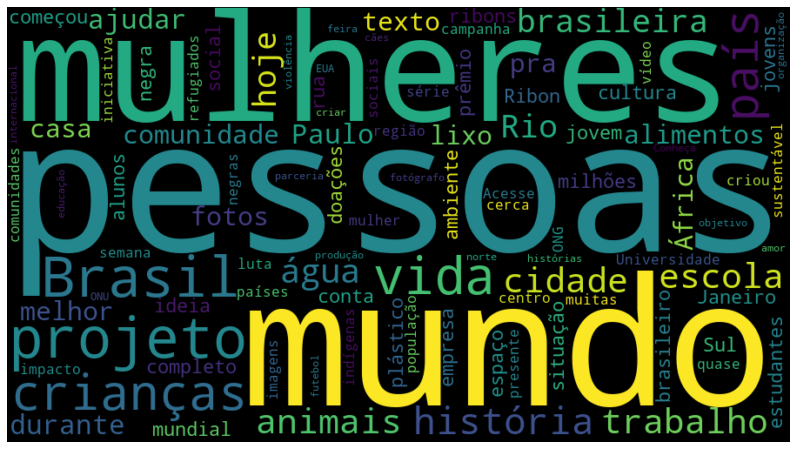

pessoas       237
mundo         205
Brasil        181
mulheres      167
projeto       150
vida          145
crianças      135
país          123
história      100
animais        88
cidade         88
trabalho       86
água           81
ajudar         80
Rio            79
Paulo          77
escola         70
texto          68
lixo           67
completo       64
África         64
hoje           63
brasileira     63
ideia          63
comunidade     63
dtype: int64


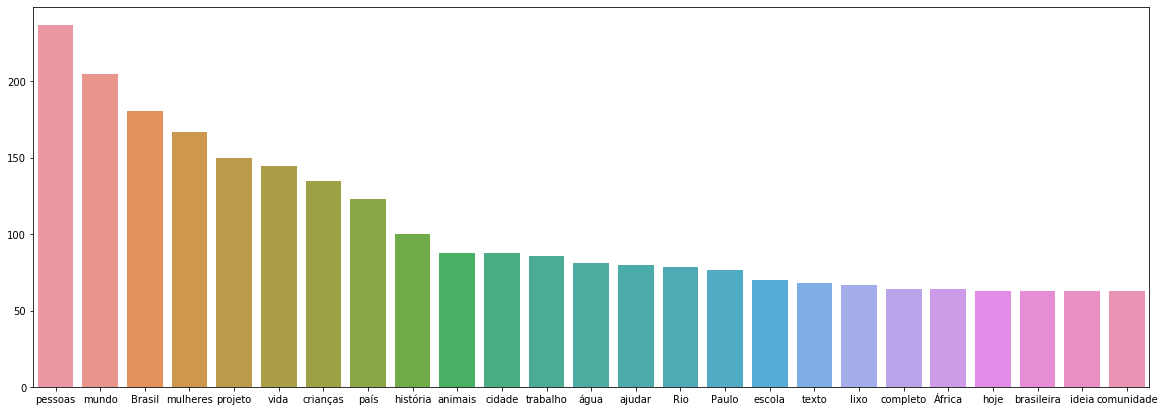

In [190]:
''' Processing text on caracteres level'''
df_data['PREPROCESSED_TEXT'] = df_data[text_variable]
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(
    number_pattern, " ")
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(
    stopword_pattern, " ", case=False)
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(
    symbols_pattern, " ")
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.replace(
    space_pattern, " ")
df_data['PREPROCESSED_TEXT'] = df_data['PREPROCESSED_TEXT'].str.strip()
generate_wordcloud(df_data['PREPROCESSED_TEXT'])
print(generate_freq_dist_plot(df_data['PREPROCESSED_TEXT']))

### Results
Now the most common words are way more expressive.

### Lemmatizing and stemming


Pipe already present.
['tagger', 'sentencizer', 'parser', 'ner']



Documents without lemmatization
pessoas       237
mundo         205
Brasil        181
mulheres      167
projeto       150
vida          145
crianças      135
país          123
história      100
animais        88
cidade         88
trabalho       86
água           81
ajudar         80
Rio            79
Paulo          77
escola         70
texto          68
lixo           67
completo       64
África         64
melhor         63
brasileira     63
ideia          63
alimentos      63
dtype: int64


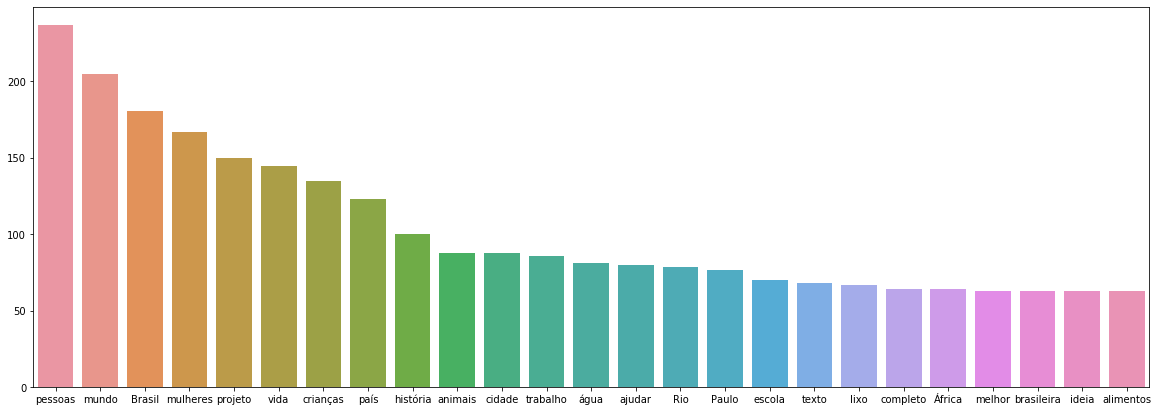

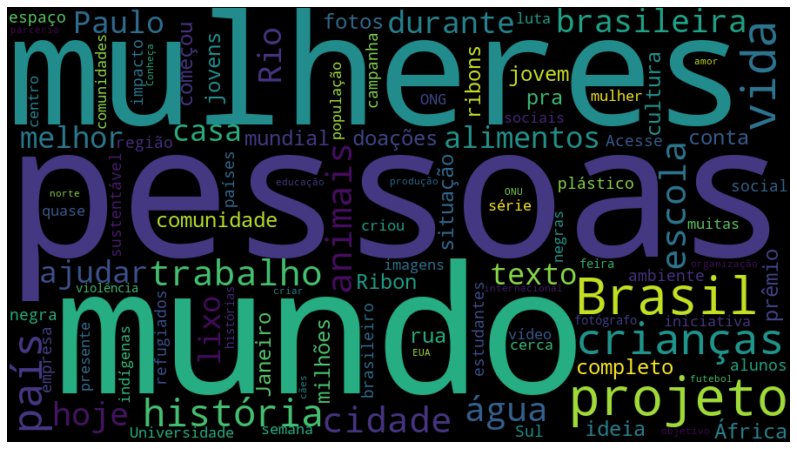

Documents with minor lemmatization
pessoas       243
mundo         221
mulheres      197
projeto       186
brasil        181
vida          150
crianças      140
país          128
história      105
trabalho       92
cidade         90
escola         90
animais        89
água           83
rio            82
brasileira     82
hoje           82
ajudar         80
durante        79
paulo          77
lixo           71
alimentos      69
casa           69
melhor         68
texto          68
dtype: int64


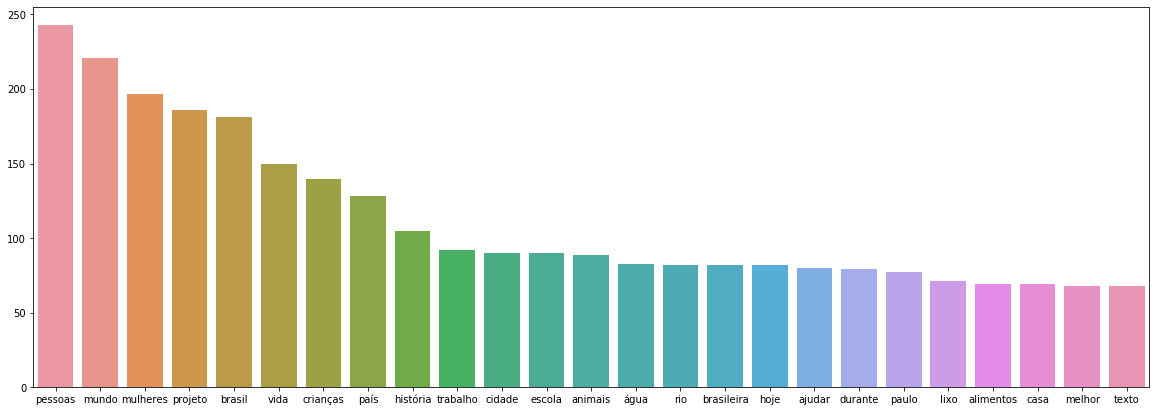

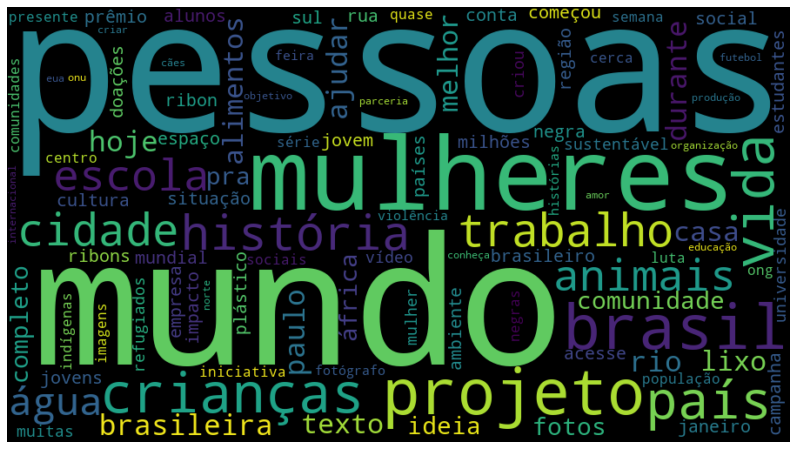

Documents with full lemmatization
pessoa        255
mundo         205
mulher        204
criar         186
Brasil        181
ajudar        170
vidar         169
país          165
passar        159
criança       151
projeto       150
trabalhar     150
brasileiro    148
história      135
casar         118
cidade        114
negro         111
contar        105
comunidade    100
fazer          99
escola         96
animar         92
começar        90
jovem          90
viver          89
dtype: int64


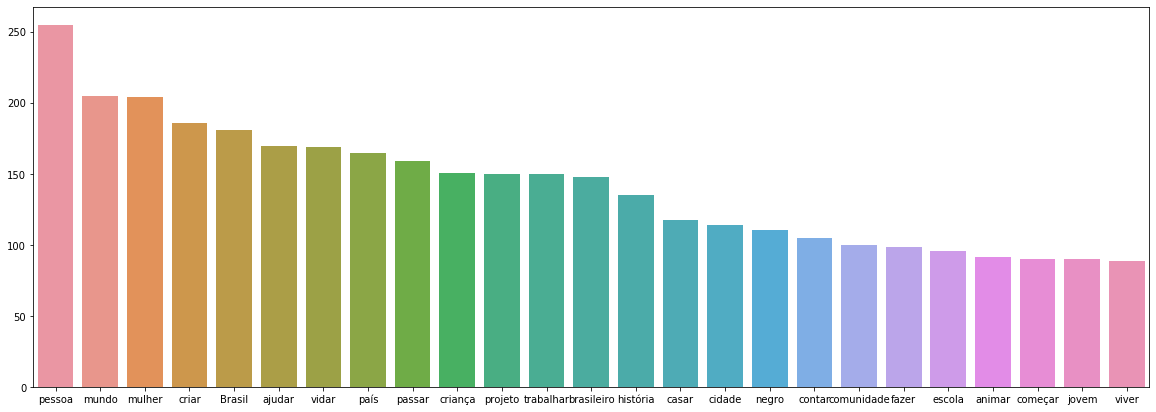

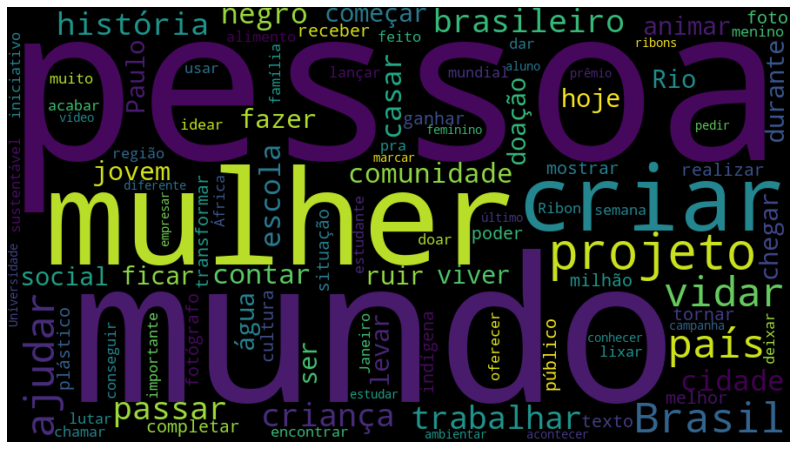

In [191]:
preprocessed_text_data = df_data['PREPROCESSED_TEXT'].to_list()
''' Not all variables are being undestood as strings so we have to force it'''

sentencizer = NLP_SPACY.create_pipe('sentencizer')
''' Create the pipeline 'sentencizer' component '''

try:
    ''' We then add the component to the pipeline if we hadn't done before '''
    NLP_SPACY.add_pipe(sentencizer, before='parser')
except ValueError:
    print("Pipe already present.")

print(NLP_SPACY.pipe_names)

tokenized_data = []
semantics_data = []
lemmatized_doc = []
normalized_doc = []
raw_doc = []
for row in tqdm(preprocessed_text_data):
    doc = NLP_SPACY(row)
    tokenized_data.append(doc)
    raw_doc.append(
        " ".join(
            [word.text for word in doc]))
    lemmatized_doc.append(
        " ".join(
            [word.lemma_ for word in doc]))
    normalized_doc.append(
        " ".join(
            [word.norm_ for word in doc]))
    
df_data['RAW_DOC'] = raw_doc
df_data['NORMALIZED_DOC'] = normalized_doc
df_data['LEMMATIZED_DOC'] = lemmatized_doc

print("Documents without lemmatization")
print(generate_freq_dist_plot(df_data['RAW_DOC']))
generate_wordcloud(df_data['RAW_DOC'])
print("Documents with minor lemmatization")
print(generate_freq_dist_plot(df_data['NORMALIZED_DOC']))
generate_wordcloud(df_data['NORMALIZED_DOC'])
print("Documents with full lemmatization")
print(generate_freq_dist_plot(df_data['LEMMATIZED_DOC']))
generate_wordcloud(df_data['LEMMATIZED_DOC'])



### Entity Recognition
Some parts of speech may mislead the model associating classes to certain entities that are not really related to the categories.
The NER model(spacy portuguese) we are using uses the following labels:

| TYPE | DESCRIPTION |
|------|-------------------------------------------------------------------------------------------------------------------------------------------|
| PER | Named person or family. |
| LOC | Name of politically or geographically defined location (cities, provinces, countries, international regions, bodies of water, mountains). |
| ORG | Named corporate, governmental, or other organizational entity. |
| MISC | Miscellaneous entities, e.g. events, nationalities, products or works of art. |

Let's take a look at the named persons or families

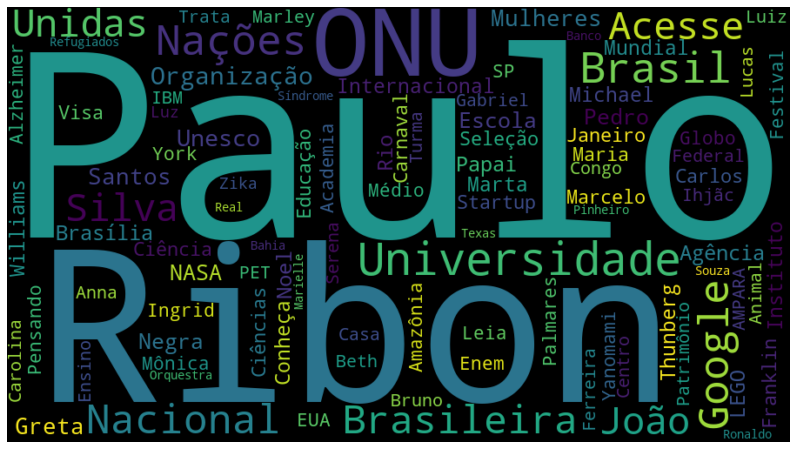

Paulo           46
Ribon           46
ONU             30
Universidade    19
Brasil          17
Nações          16
Google          16
Nacional        15
Acesse          14
Unidas          14
Silva           14
João            14
Greta           12
Santos          12
Brasileira      12
Organização     11
Pedro           11
Mulheres        11
Rio             10
Escola          10
Papai           10
Brasília        10
Negra           10
Noel            10
Michael          9
dtype: int64


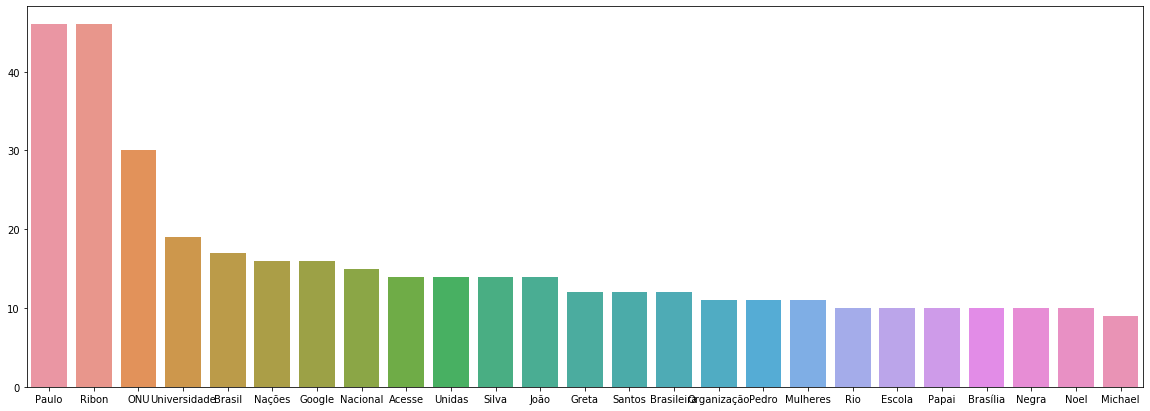

In [192]:
''' First we take a look at the found entities'''
entities_lists = []
entity_unwanted_types = set(['PER', 'ORG'])

for docs in tokenized_data:
    entities_text = ""
    for entity in docs.ents:
        if entity.label_ in entity_unwanted_types:
            entities_text += " " + entity.text
    entities_text = entities_text.strip()
    entities_lists.append(entities_text)
            
df_data['ENTITIES'] = entities_lists
generate_wordcloud(df_data['ENTITIES'])
print(generate_freq_dist_plot(df_data['ENTITIES']))

### Removing Entities

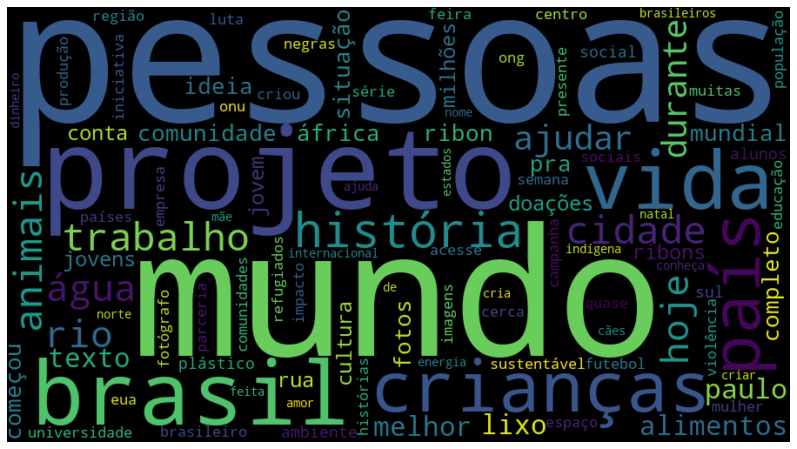

pessoas       243
mundo         221
projeto       186
brasil        181
vida          150
crianças      140
país          128
história      105
trabalho       92
cidade         90
animais        89
água           83
hoje           82
rio            82
ajudar         80
durante        79
paulo          77
lixo           71
alimentos      69
texto          68
melhor         68
comunidade     67
pra            66
fotos          65
completo       64
dtype: int64


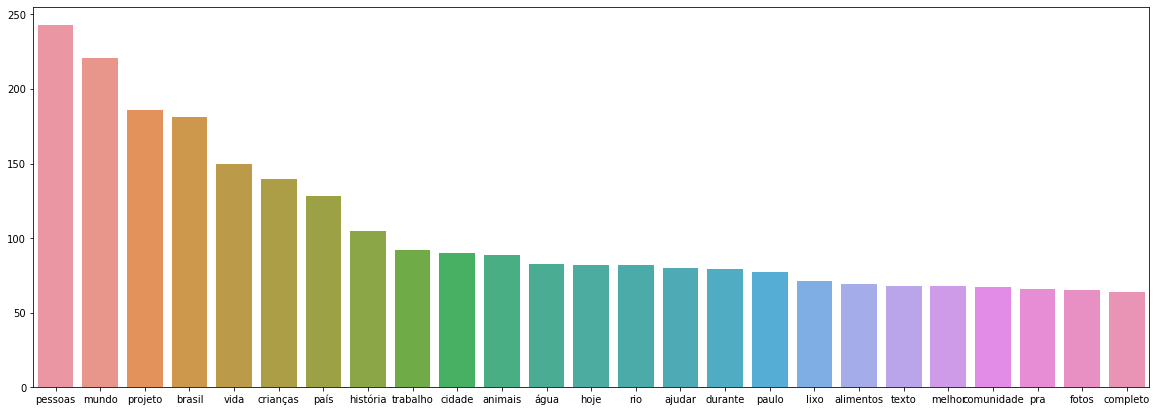

In [193]:
entities_set = set()
entities_set = set([ word for word_list in list(map(list, df_data['ENTITIES'].str.split(" ")))
                            for word in word_list ])
entities_set.remove("")
entities_pattern = r'\b(?:{})\b'.format('|'.join(entities_set)) 

''' Processing text on entity level'''
df_data['PROCESSED_DOC'] = df_data['NORMALIZED_DOC'].str.replace(entities_pattern, " ")
generate_wordcloud(df_data['PROCESSED_DOC'])
print(generate_freq_dist_plot(df_data['PROCESSED_DOC']))

### POS Analysis
Let's take a look in the parts of speech presents in the dataset

PROPN    13662
NOUN     10446
VERB      9525
ADJ       6800
ADV        897
DET        512
AUX        311
ADP        308
PRON        79
SYM         72
X           52
NUM         33
CCONJ       20
SCONJ       12
PUNCT        9
SPACE        8
PART         2
dtype: int64


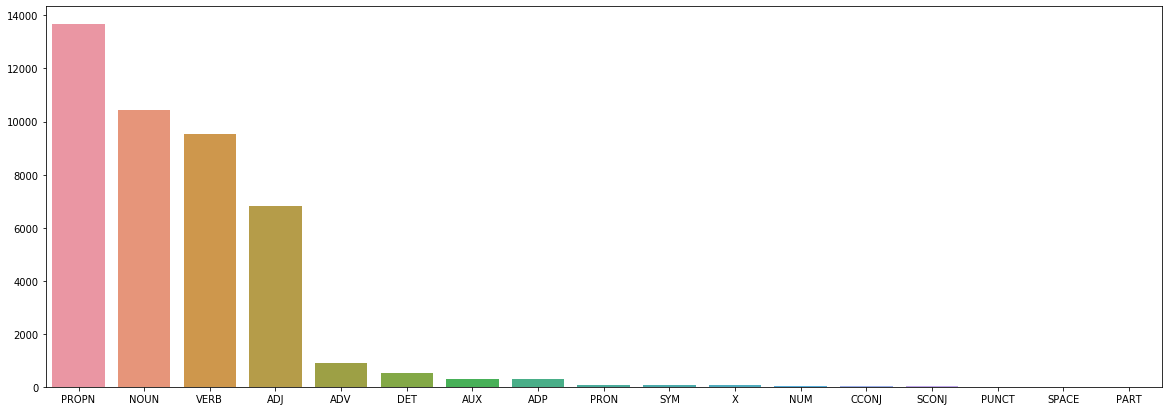

In [194]:
semantics_data = []
for doc in tokenized_data:
    semantics_data.append(" ".join([word.pos_ for word in doc]))

df_data['SEMANTICS'] = semantics_data
print(generate_freq_dist_plot(df_data['SEMANTICS']))

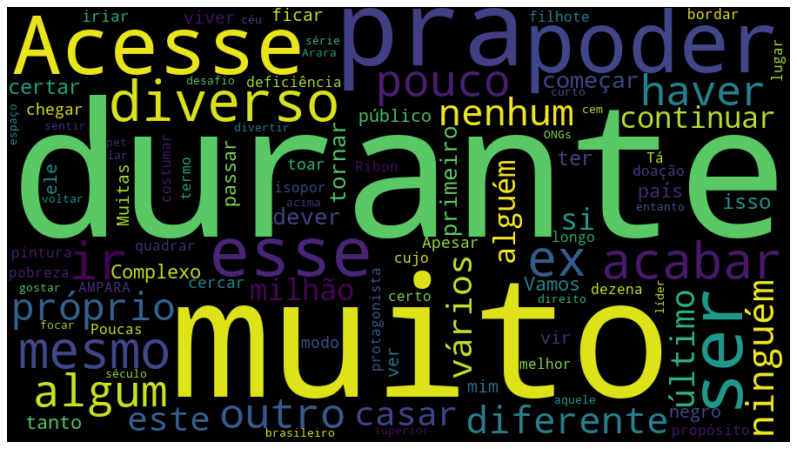

muito        63
pra          61
durante      59
poder        45
Acesse       41
d            40
ser          33
esse         29
o            28
diverso      26
ir           22
mesmo        22
n            22
acabar       21
Durante      20
D            16
pouco        16
algum        16
outro        15
haver        15
º            15
próprio      14
ex           14
diferente    13
nenhum       11
dtype: int64


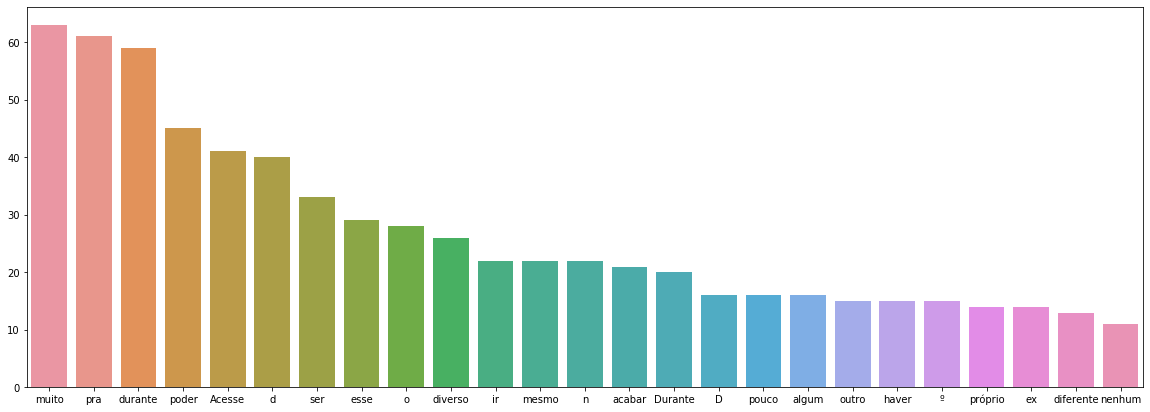

In [195]:
ALLOWED_POS = set(["PROPN", "NOUN", "ADV", "ADJ", "VERB"])

unwanted_pos_text = []
for doc in tokenized_data:
    unwanted_pos_text.append(
        " ".join(
            [word.lemma_ if not str(word.pos_) in ALLOWED_POS else "" for word in doc]))
    
df_data['UNWANTED_POS'] = unwanted_pos_text
generate_wordcloud(df_data['UNWANTED_POS'])
print(generate_freq_dist_plot(df_data['UNWANTED_POS']))

### Removing POS

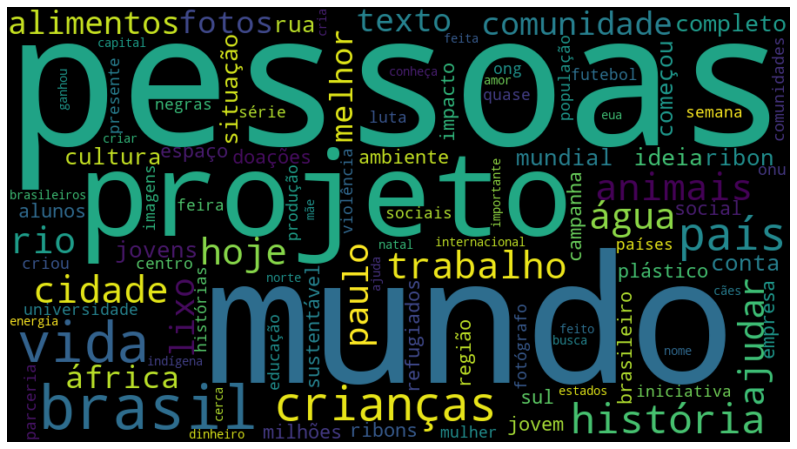

pessoas       243
mundo         221
projeto       186
brasil        181
vida          150
crianças      140
país          128
história      105
trabalho       92
cidade         90
animais        88
água           83
hoje           82
rio            81
ajudar         79
paulo          77
lixo           71
alimentos      68
texto          68
comunidade     67
melhor         65
fotos          65
completo       64
áfrica         64
ideia          63
dtype: int64


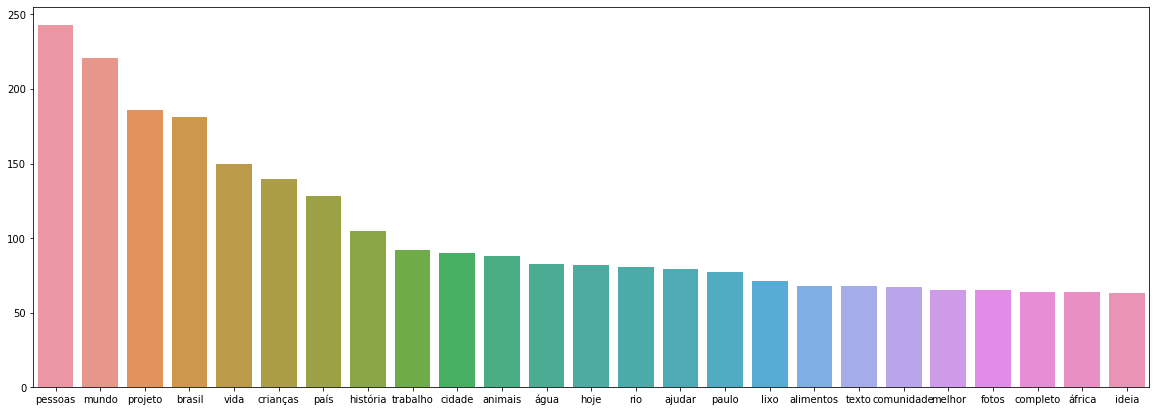

In [196]:
ALLOWED_POS = set(["PROPN", "NOUN", "ADV", "ADJ", "VERB"])

processed_doc = []
for doc in tokenized_data:
    processed_doc.append(
        " ".join(
            [word.norm_ if str(word.pos_) in ALLOWED_POS else "" for word in doc]))

df_data['PROCESSED_DOC'] = processed_doc
''' Processing text on entity level again '''
df_data['PROCESSED_DOC'] = df_data['PROCESSED_DOC'].str.replace(entities_pattern, " ")
generate_wordcloud(df_data['PROCESSED_DOC'])
print(generate_freq_dist_plot(df_data['PROCESSED_DOC']))

In [197]:
""" Removing extra spaces originated from processing """
df_data['PROCESSED_DOC'] = df_data['PROCESSED_DOC'].str.replace(space_pattern, " ").str.strip()
df_data['UNWANTED_POS'] = df_data['UNWANTED_POS'].str.replace(space_pattern, " ").str.strip()

### Viewing the most common words for each label

Label:  CELEBRACAO
mundo            16
brasil           15
trabalho         15
ciência          13
jovens           13
nobel            12
país             11
internacional    11
pessoas          10
vida             10
greta            10
bióloga          10
projeto          10
onu               9
sul               8
paz               8
jovem             7
música            7
história          7
ficou             7
universidade      7
recebe            7
leite             7
brasileiro        7
notícias          6
dtype: int64


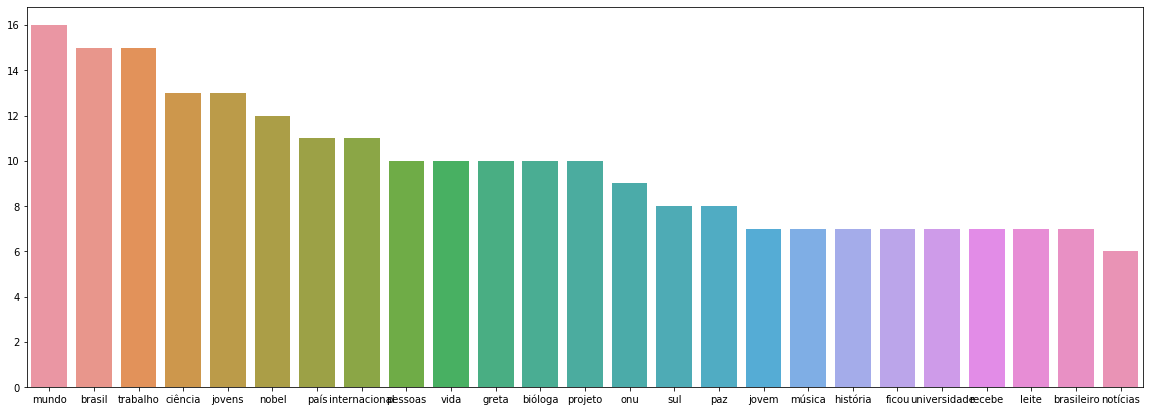

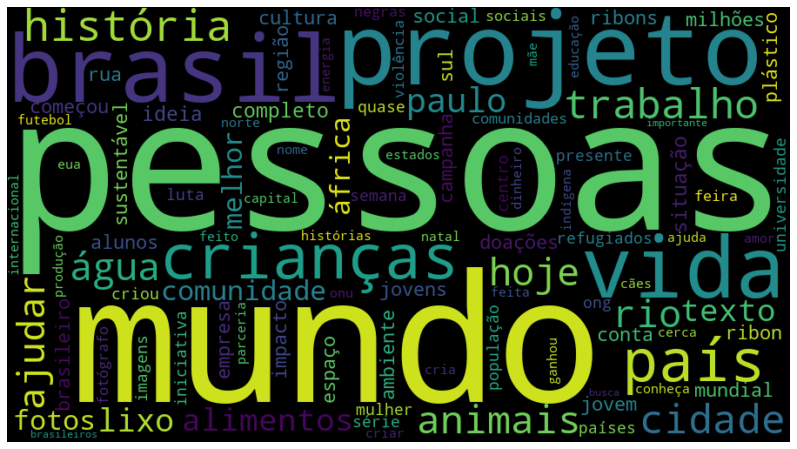

Label:  DIVERSIDADE
pessoas            27
braille            17
crianças           17
brasil             15
mundo              15
projeto            13
luta               12
nome               10
diversidade        10
lei                10
inclusão            9
visuais             9
lego                9
igualdade           9
pele                9
hoje                9
social              9
gênero              8
empresa             8
desenvolvimento     8
direitos            8
sociais             8
campanha            7
joão                7
paulo               7
dtype: int64


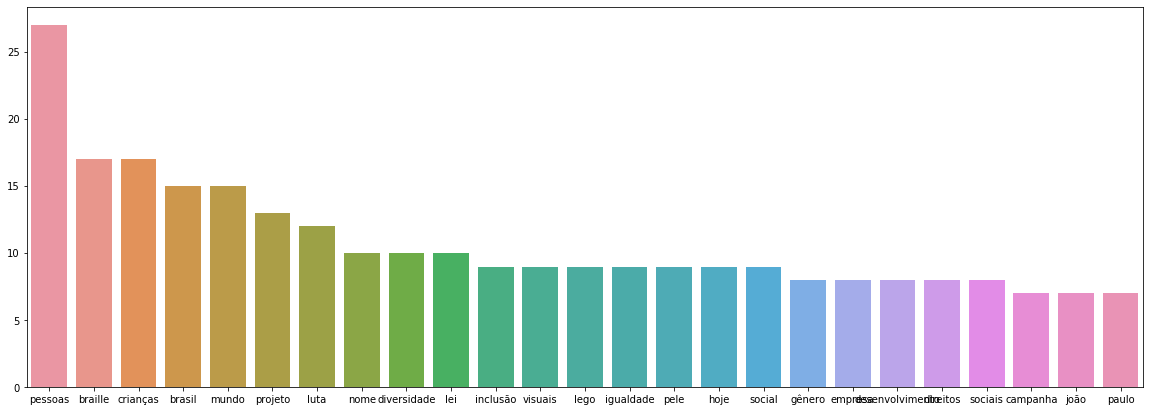

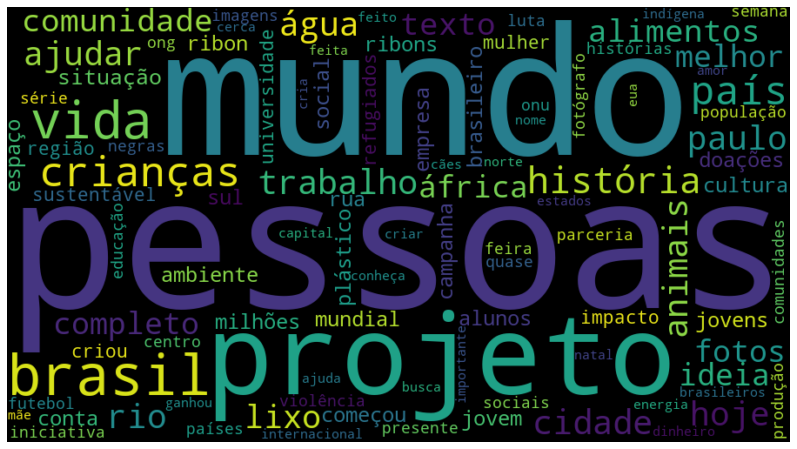

Label:  CULTURA
brasil         42
rio            25
mundo          24
história       23
cultura        21
cultural       18
pessoas        17
texto          15
fotos          15
vida           15
completo       14
carnaval       14
fotógrafo      13
patrimônio     13
resistência    12
paulo          12
negros         12
hoje           11
negras         10
terra          10
livro          10
povos          10
mulher          9
blocos          9
luta            9
dtype: int64


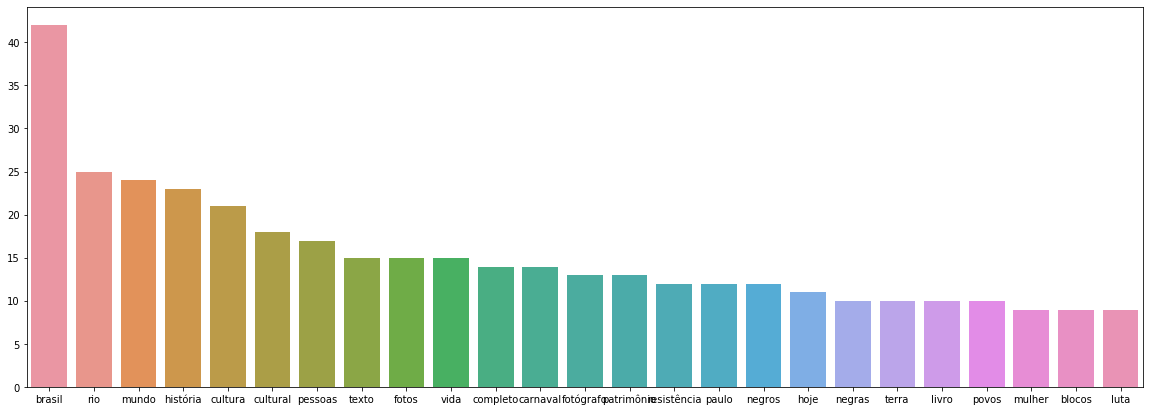

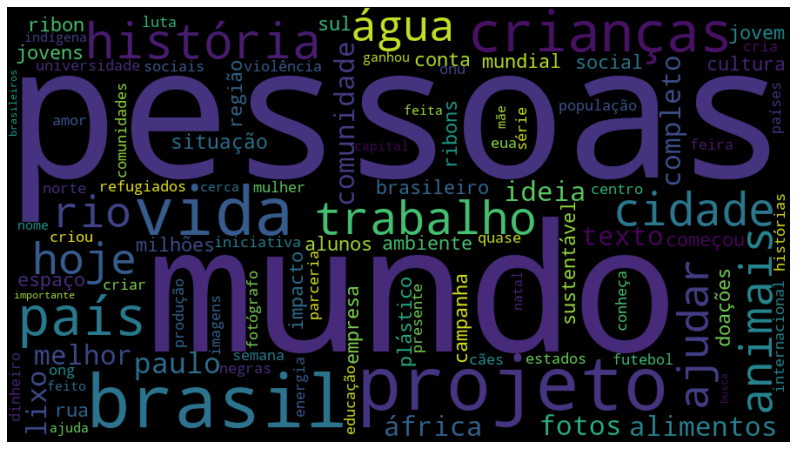

Label:  ANIMAIS
animais        69
cães           36
vida           22
animal         21
elefantes      18
cachorros      14
extinção       13
pessoas        13
gatos          12
rua            12
ong            11
amor           10
espécie        10
mundo          10
abandonados    10
espécies       10
país            9
situação        9
cão             9
vira            8
quênia          8
ambiente        8
texto           8
cidade          8
ideia           8
dtype: int64


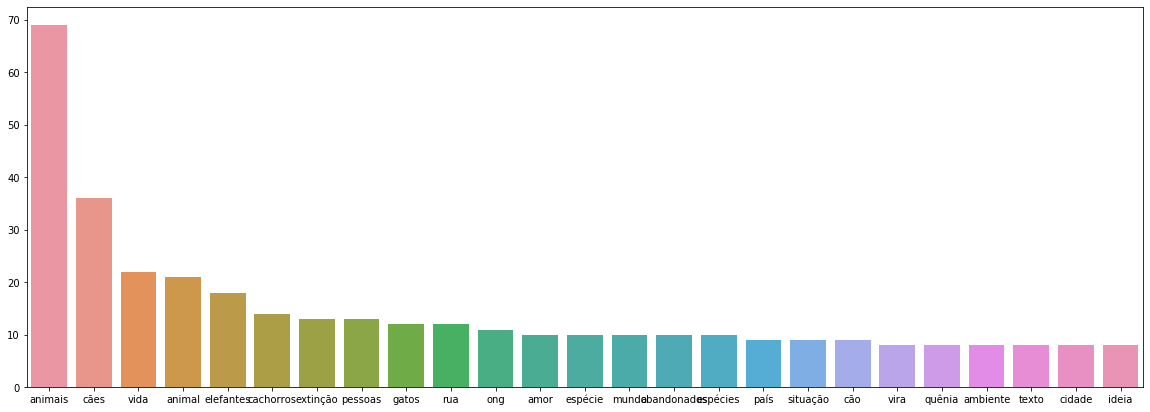

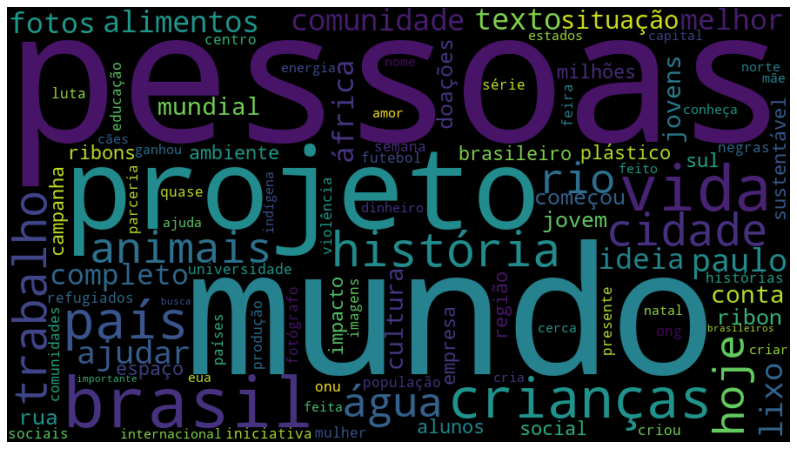

Label:  EMPREENDEDORISMO
projeto        26
pessoas        18
mundo          15
alimentos      15
violência      13
brasil         12
trabalho       10
comunidades     9
algodão         9
situação        9
projetos        8
produção        8
vida            8
iniciativa      8
paulo           7
social          7
onu             7
negras          7
comunidade      7
país            7
sp              7
ajudar          6
problemas       6
dinheiro        6
máquina         6
dtype: int64


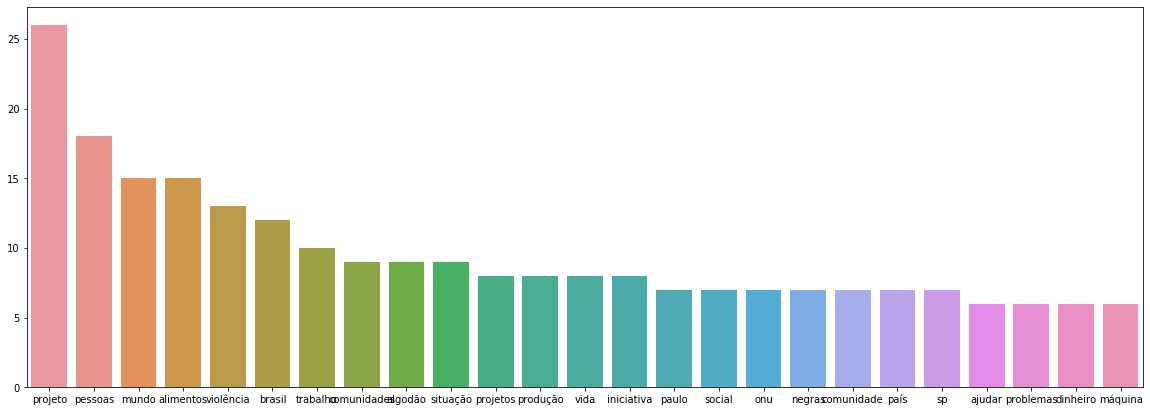

Label:  EDUCACAO
crianças        35
projeto         28
alunos          27
educação        20
escolas         17
brasil          17
mundo           16
rio             14
trabalho        12
ensino          12
melhor          12
pessoas         12
enem            12
país            11
universidade    11
livros          11
música          11
cidade          11
aulas           10
professor       10
centro           9
vida             9
nacional         9
pública          9
professora       8
dtype: int64


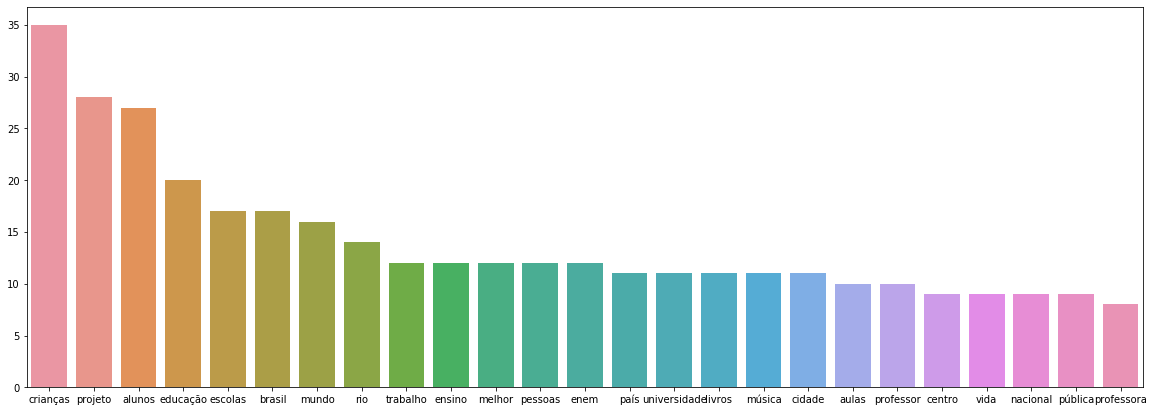

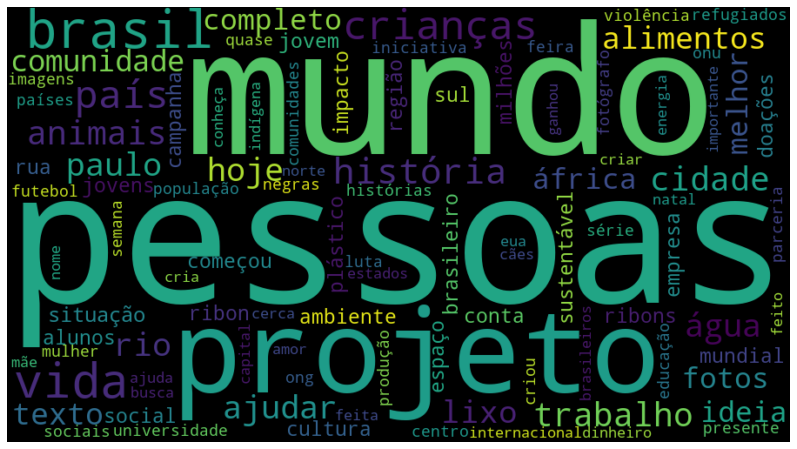

Label:  PROPOSITO
ribons        46
ribon         43
doações       35
pessoas       25
mundo         23
impacto       20
presente      19
visa          16
completo      16
ajudar        16
comunidade    16
texto         15
doados        15
boas          14
projeto       13
doadores      12
doação        11
crianças      11
milhões       11
hoje          11
causas        10
ajude         10
trabalho      10
juntos        10
usuários      10
dtype: int64


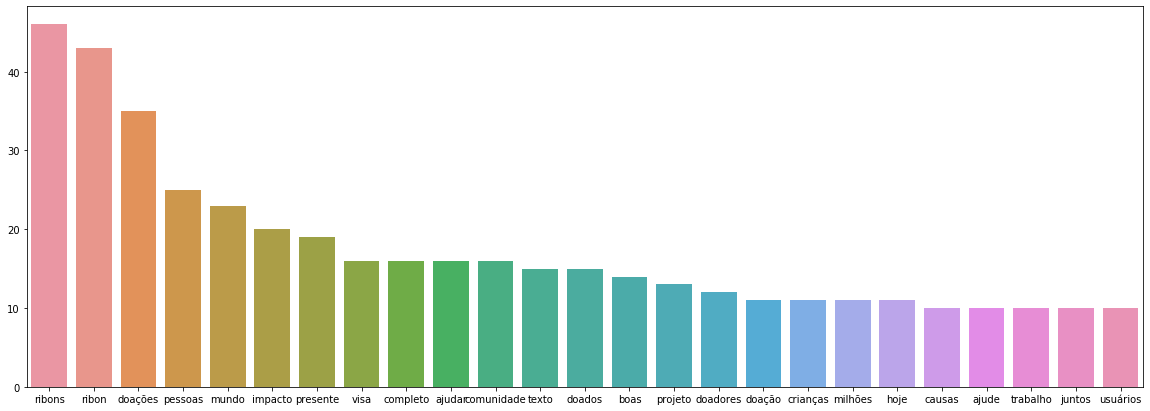

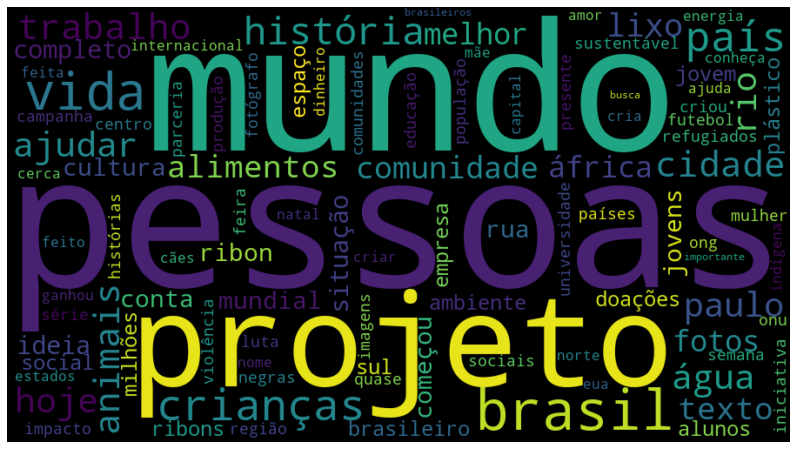

Label:  ETNIAS
país          29
áfrica        23
mundo         22
fotos         22
brasil        20
cultura       17
história      16
indígena      16
série         15
pessoas       15
fotógrafo     15
vida          14
povos         14
continente    14
hoje          14
imagens       13
texto         12
região        11
completo      11
congo         10
guerra        10
floresta       9
jeito          9
projeto        9
beleza         8
dtype: int64


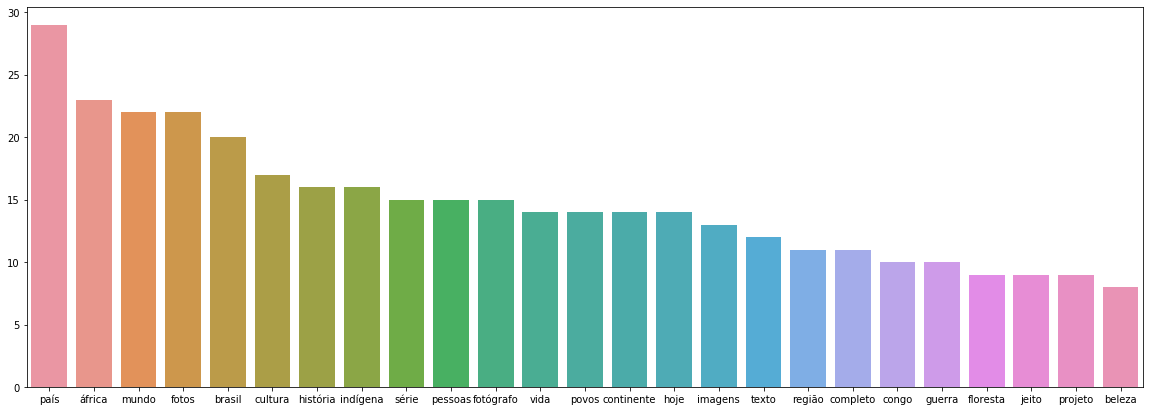

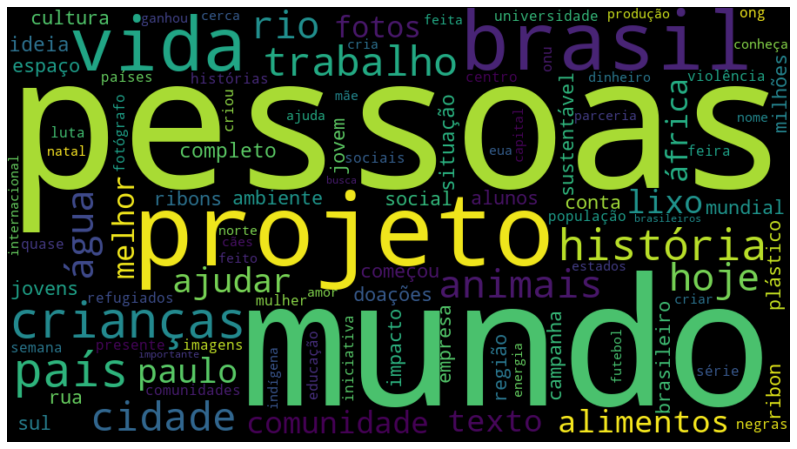

Label:  ESPORTE
futebol         27
seleção         20
mundo           19
copa            18
mundial         14
brasil          13
história        12
feminino        10
projeto         10
feminina        10
jogos           10
histórias       10
atletas          9
esporte          8
pessoas          8
país             8
atleta           7
campeonato       7
melhor           6
conta            6
masculino        6
camisa           6
participação     6
marta            6
jogadora         6
dtype: int64


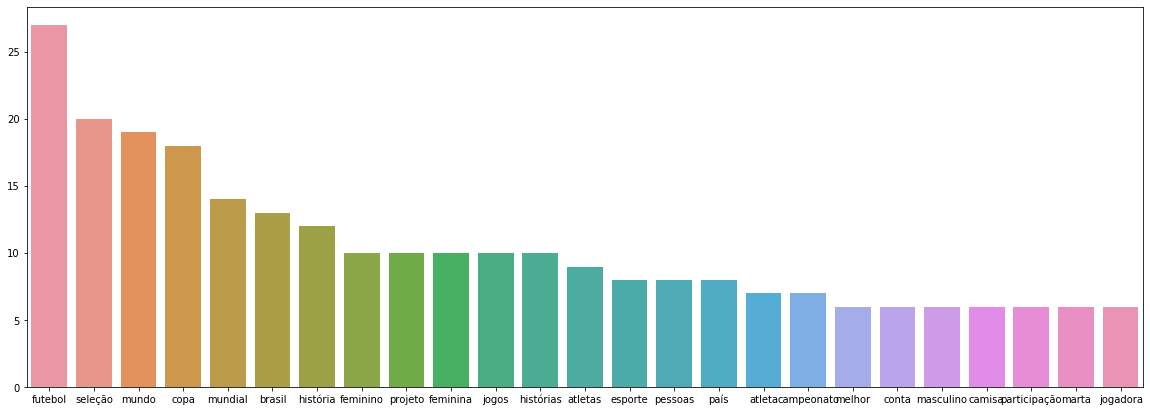

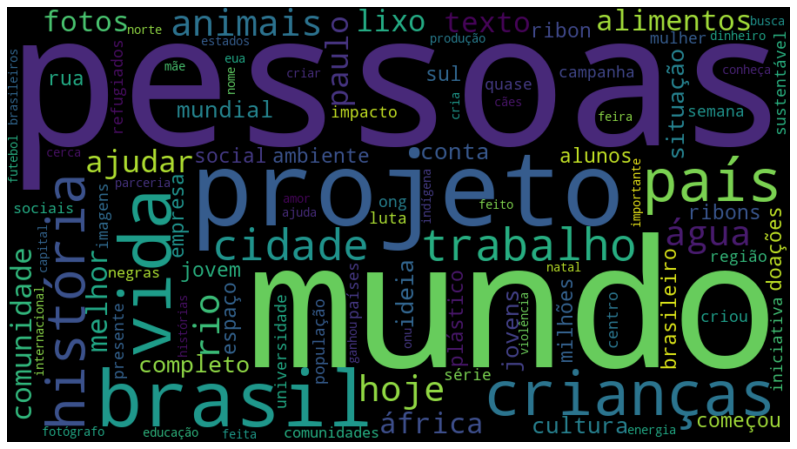

Label:  SAUDE
pessoas      15
saúde         8
morte         8
vida          7
mundo         6
médico        6
natureza      6
pacientes     6
escrever      5
projeto       5
libras        5
brasil        5
crianças      5
ajudar        5
corpo         4
ouvido        4
cirurgia      4
acesso        4
melhor        4
doenças       4
pesquisa      4
igor          4
ajuda         4
diversão      4
pesquisas     4
dtype: int64


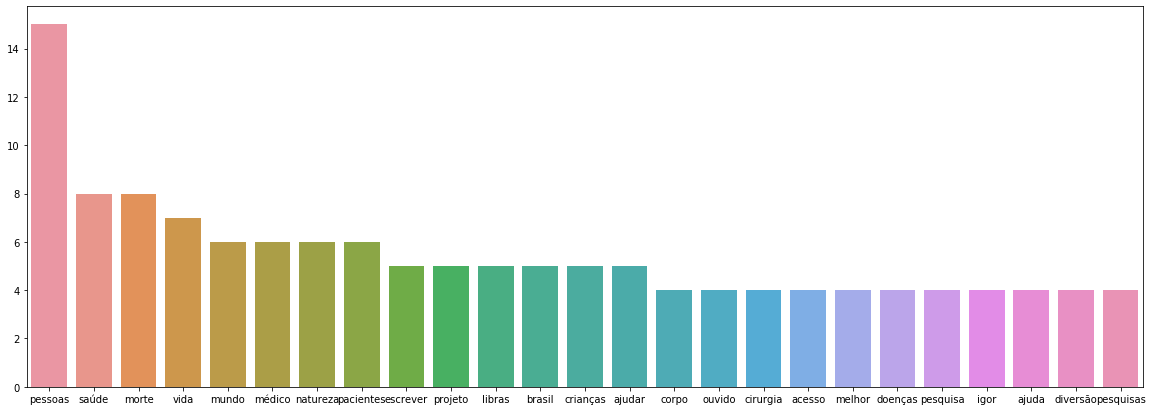

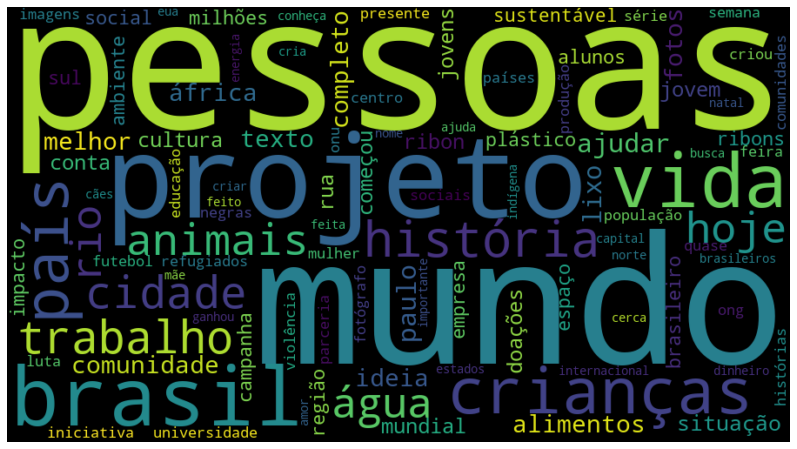

Label:  CIENCIA
água            16
nasa            14
espaço          11
jovem           10
espacial        10
tecnologia       9
criou            9
sinais           8
pessoas          7
cientistas       7
ciência          7
estados          6
brasileiro       6
lixo             6
ideia            6
garrafa          6
unidos           6
christina        5
missão           5
universidade     5
lua              5
astronautas      5
imagens          5
transformar      5
mundo            5
dtype: int64


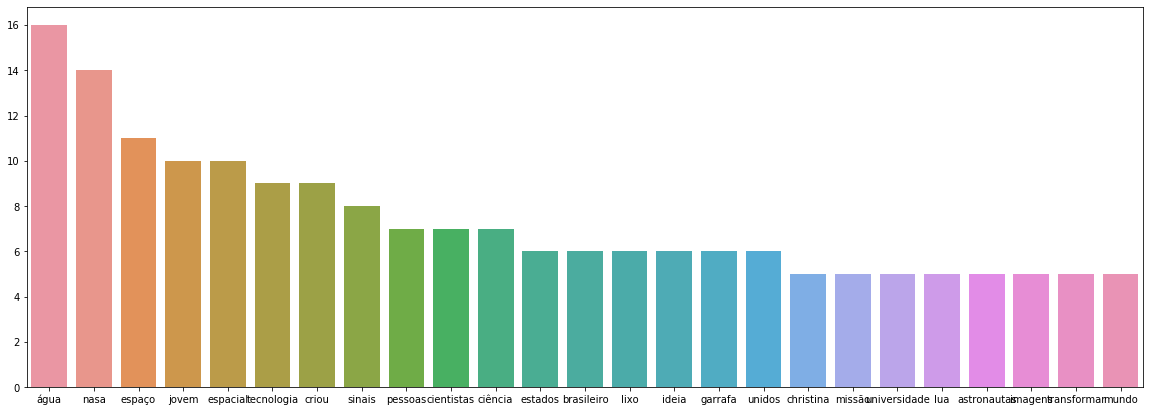

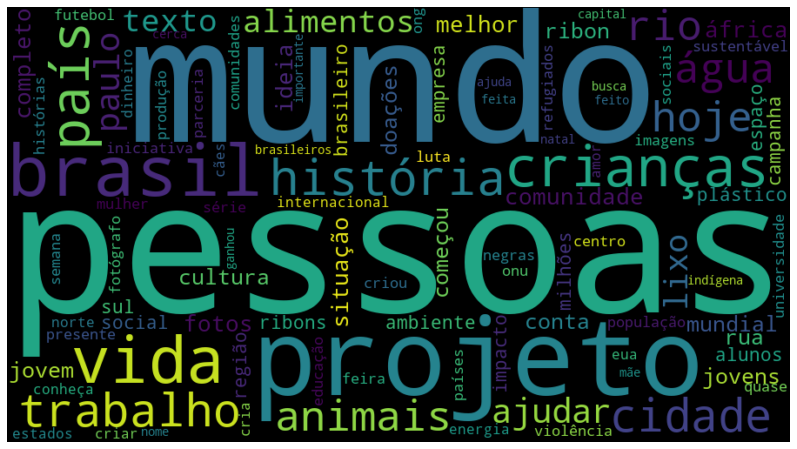

Label:  SCARCE_GROUP
crianças    22
mãe         18
vida        13
amor        12
história    11
mundo       11
pessoas     10
filha       10
cidade       9
pai          9
mães         8
natal        8
idosos       8
filhos       8
começou      7
hoje         6
paulo        6
fotos        6
criança      6
árvores      5
pais         5
bebês        5
williams     5
hospital     5
conta        5
dtype: int64


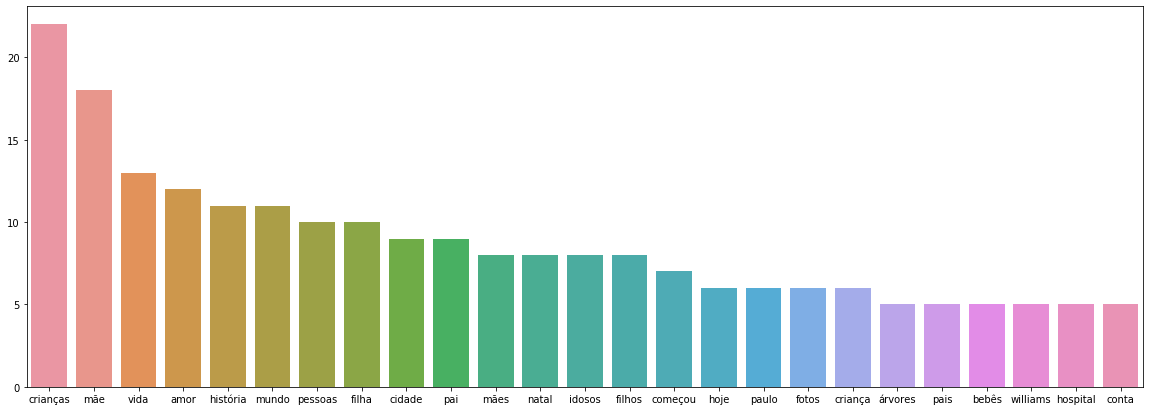

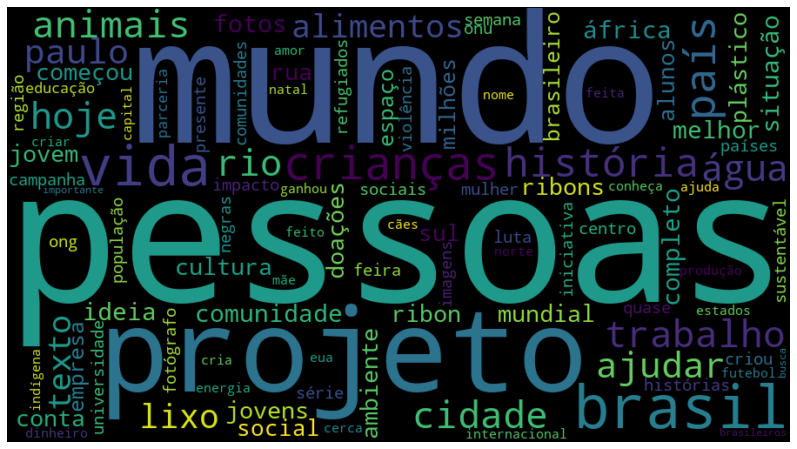

Label:  ECOLOGIA
lixo           46
plástico       41
água           38
mundo          26
projeto        25
sustentável    25
energia        22
ambiente       21
brasil         18
empresa        17
feita          17
pessoas        17
árvores        15
vida           14
resíduos       14
cidade         14
população      14
solar          13
garrafas       12
ideia          12
materiais      11
mundial        11
produção       10
coleta         10
história       10
dtype: int64


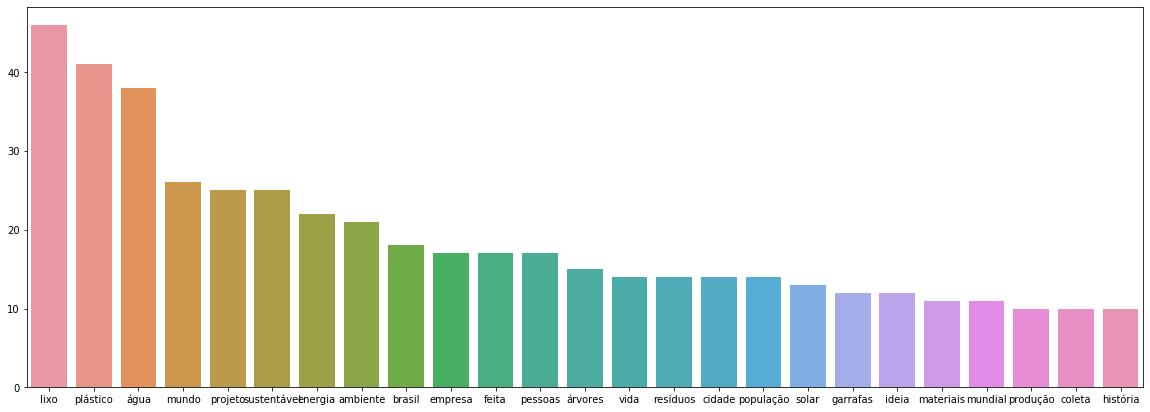

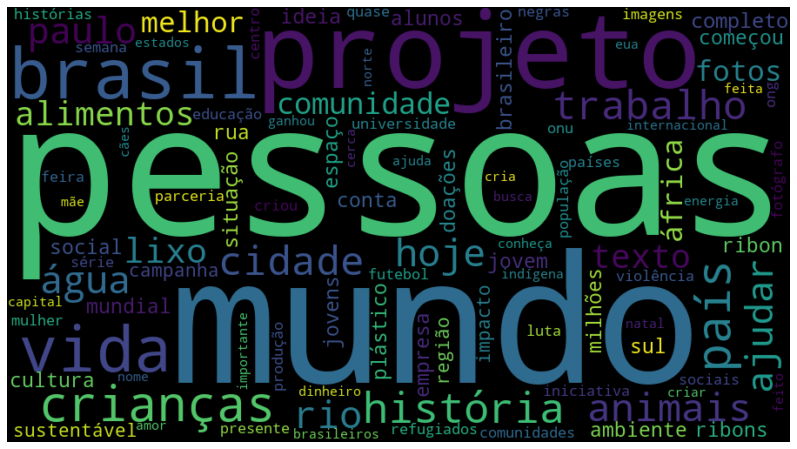

Label:  SOLIDARIEDADE
pessoas        49
ajudar         25
projeto        24
alimentos      23
refugiados     21
crianças       21
vida           19
situação       18
rua            18
rio            13
mundo          13
comida         12
brumadinho     12
comprar        12
país           11
brasil         11
homem          11
ong            10
começou        10
voluntários    10
moradores      10
campanha       10
cidade         10
vítimas         9
semana          9
dtype: int64


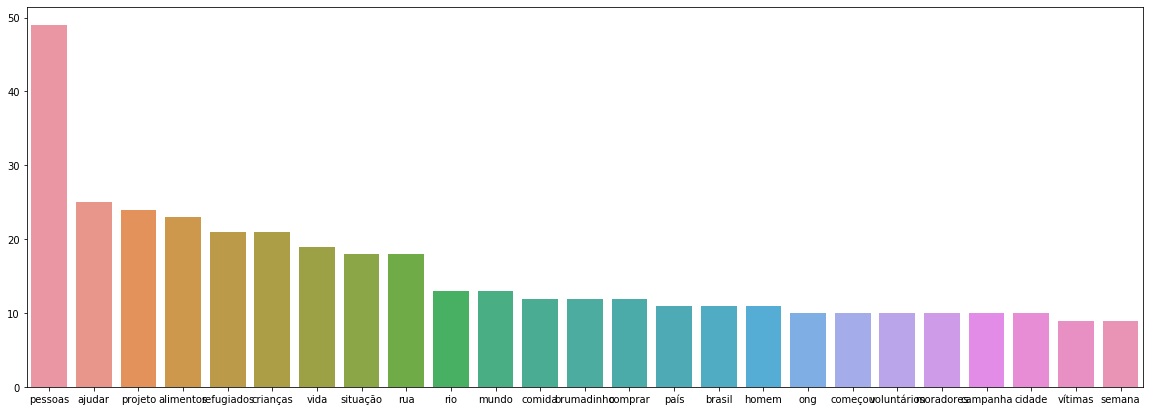

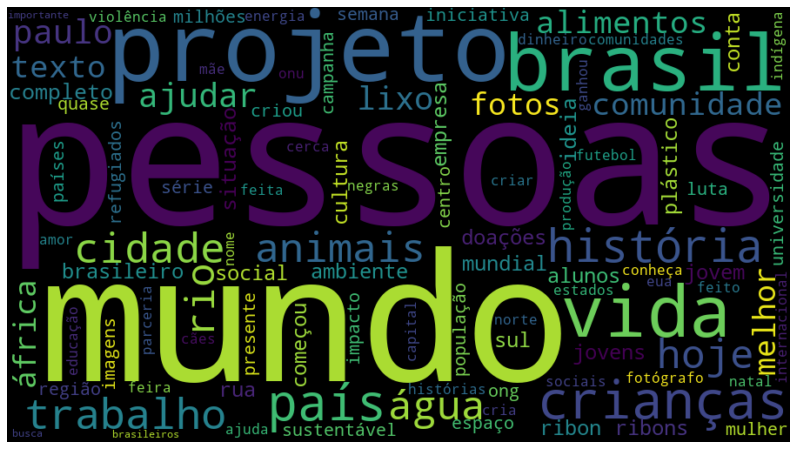

In [198]:
target_labels = df_data[TARGET_VARIABLE].unique()

for label in target_labels:
    words_for_label = df_data[df_data[TARGET_VARIABLE] == label]
    print("Label: ", label)
    print(generate_freq_dist_plot(words_for_label['PROCESSED_DOC']))
    generate_wordcloud(df_data['PROCESSED_DOC'])

### Storing partial progress

In [199]:
"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_processed_data.xlsx"

In [200]:
df_data.to_excel(excel_filename)

 ## Text Parser(Counting and vectorizing)
 Now we have clear tokens we can measure how much they affect the outcome prediction and how many of them exist in each sample.

In [201]:
"""  We then load the data for stability """
df_processed_data = pd.read_excel(excel_filename, index_col=0)
print(df_processed_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1679 entries, 53 to 657
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   LABEL_TRAIN        1679 non-null   object
 1   TEXT_VARIABLE      1679 non-null   object
 2   PREPROCESSED_TEXT  1679 non-null   object
 3   RAW_DOC            1679 non-null   object
 4   NORMALIZED_DOC     1679 non-null   object
 5   LEMMATIZED_DOC     1679 non-null   object
 6   ENTITIES           932 non-null    object
 7   PROCESSED_DOC      1677 non-null   object
 8   SEMANTICS          1679 non-null   object
 9   UNWANTED_POS       675 non-null    object
dtypes: object(10)
memory usage: 144.3+ KB
None


### Dealing with missing values
As there are some samples without content, they'll not be useful to train or to validate the model. 
Hapilly they're not many so let's drop them.

In [202]:
missing_variables = ['ENTITIES', 'UNWANTED_POS']
df_processed_data = df_processed_data.drop(columns=missing_variables).dropna()
print(df_processed_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1677 entries, 53 to 657
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   LABEL_TRAIN        1677 non-null   object
 1   TEXT_VARIABLE      1677 non-null   object
 2   PREPROCESSED_TEXT  1677 non-null   object
 3   RAW_DOC            1677 non-null   object
 4   NORMALIZED_DOC     1677 non-null   object
 5   LEMMATIZED_DOC     1677 non-null   object
 6   PROCESSED_DOC      1677 non-null   object
 7   SEMANTICS          1677 non-null   object
dtypes: object(8)
memory usage: 117.9+ KB
None


### Choosing best parameters for Counting and Vectorizing

In [203]:
is_gridsearching = False
if is_gridsearching:
    from sklearn.metrics import make_scorer
    from sklearn.metrics import accuracy_score

    search_count_vectorizer = CountVectorizer()
    search_tfidf_transformer = TfidfTransformer()
    clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')

    search_params = {
        'vect__min_df': np.arange(0, 0.001, 0.0003),
        'vect__max_df': np.arange(0.2, 0.9, 0.3),
        'vect__max_features': [None],
        'vect__ngram_range': [(1, 2), (1, 3), (2, 3)],
        'tfidf__norm': ['l2'],
        'tfidf__use_idf': [False, True],
        'tfidf__smooth_idf': [False],
        'tfidf__sublinear_tf' : [False, True]}

    search_pipeline = Pipeline([
        ('vect', search_count_vectorizer),
        ('tfidf', search_tfidf_transformer),
        ('clf', clf)
    ])

    gs = GridSearchCV(search_pipeline,
                      param_grid=search_params, cv=5)
    gs.fit(df_data['PROCESSED_DOC'].values, df_data[TARGET_VARIABLE])
    results = gs.cv_results_
    print(results)

In [204]:
print(gs.best_params_)

{'tfidf__norm': 'l1', 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vect__max_df': 0.6000000000000001, 'vect__max_features': None, 'vect__min_df': 0.0007, 'vect__ngram_range': (1, 2)}


In [206]:
''' Best parameter using GridSearch (CV score=0.535):
{'clf__alpha': 1e-05, 'clf__max_iter': 80, 'clf__penalty': 'l2', 'tfidf__norm': 'l1',
'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True,
'vect__max_df': 0.6000000000000001, 'vect__max_features': None, 'vect__min_df': 0.0007,
'vect__ngram_range': (1, 2)}
'''
''' Text Parser
    This part is responsible to give weights to important tokens and remove
    weight for unwanted ones or those who can be misguiding.
    - Frequency Counter
    - Id-IdF Counter
'''
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)

''' Let's transform the lemmatized documents into count vectors '''
count_vectors = count_vectorizer.fit_transform(
    df_processed_data['PROCESSED_DOC'])

''' Then use those count vectors to generate frequency vectors '''
frequency_vectors = tfidf_transformer.fit_transform(count_vectors)

print(count_vectors[0])
print(frequency_vectors[0])

  (0, 837)	1
  (0, 3096)	1
  (0, 3639)	1
  (0, 4165)	1
  (0, 4729)	1
  (0, 4729)	0.23722144487414104
  (0, 4165)	0.2039658012591762
  (0, 3639)	0.17050482357154256
  (0, 3096)	0.21676410346673136
  (0, 837)	0.17154382682840882


In [207]:
''' Let's transform the lemmatized documents into count vectors '''
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6000000000000001, ngram_range=(1, 2))
count_vectors = count_vectorizer.fit_transform(
    df_processed_data['PROCESSED_DOC'])

mutual_info_vector = mutual_info_classif(count_vectors, df_processed_data[TARGET_VARIABLE]) 
print(mutual_info_vector)

[0.01005799 0.00294594 0.00277418 ... 0.0039515  0.0039515  0.00249319]


In [208]:
print(count_vectorizer.get_feature_names())

['abaixo', 'abaixo ler', 'abaixo média', 'abandonada', 'abandonadas', 'abandonado', 'abandonados', 'abastecer', 'abastecimento', 'abc', 'abcdelas', 'aberta', 'aberto', 'abertura', 'abl', 'abolir', 'abolir rituais', 'abolição', 'abra', 'abre', 'abrem', 'abria', 'abrigar', 'abrigo', 'abrigos', 'abril', 'abrindo', 'abrindo debate', 'abrir', 'abrir portas', 'abriram', 'abriria', 'abriu', 'absoluta', 'absolutamente', 'absoluto', 'absorvente', 'absorvente sustentável', 'absorventes', 'abstratas', 'abu', 'abundante', 'abundância', 'acaba', 'acaba eleger', 'acaba lançar', 'acaba passo', 'acabado', 'acabar', 'acabar fome', 'acabou', 'academia', 'acadêmicos', 'acalmar', 'acarajé', 'acaso', 'aceleradora', 'acelerar', 'acessar', 'acessar tela', 'acesse', 'acesse texto', 'acessibilidade', 'acesso', 'acesso água', 'acessíveis', 'acessíveis pessoas', 'acessível', 'acha', 'achamos', 'achar', 'achava', 'achem', 'acho', 'achou', 'acidentalmente', 'acidente', 'acidente carro', 'acnur', 'acolhe', 'acolher

### Model Train and Cross-Validation

In [212]:
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6000000000000001, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)
clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')

pipeline_simple = Pipeline([
    ('clf', clf)
])
pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer),
    ('clf', clf)
])

''' Let's use cross validation to better evaluate models ''' 
scores = cross_val_score(
    pipeline_simple,
    frequency_vectors,
    df_processed_data[TARGET_VARIABLE], cv=10)
print("Mean accuracy for explicit pipeline: ", scores.mean())

scores = cross_val_score(
    pipeline,
    df_processed_data['PROCESSED_DOC'],
    df_processed_data[TARGET_VARIABLE], cv=10)
print("Mean accuracy for implicit pipeline: ", scores.mean())

Mean accuracy for explicit pipeline:  0.7017857142857142
Mean accuracy for implicit pipeline:  0.617711006558312


### Evaluating the best model

In [213]:
''' Let's evaluate more deeply the best model '''
X_train, X_test, y_train, y_test = train_test_split(
    df_processed_data['PROCESSED_DOC'],
    df_processed_data[TARGET_VARIABLE],
    test_size=0.33, random_state=42)

pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer),
    ('clf', clf)
])

train1 = X_train.tolist()
labelsTrain1 = y_train.tolist()
test1 = X_test.tolist()
labelsTest1 = y_test.tolist()
"""  train """
pipeline.fit(train1, labelsTrain1)
"""  test """
preds = pipeline.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print(
    classification_report(
        labelsTest1,
        preds,
        target_names=df_processed_data[TARGET_VARIABLE].unique()))

accuracy: 0.6155234657039711
                  precision    recall  f1-score   support

      CELEBRACAO       0.80      0.78      0.79        51
     DIVERSIDADE       0.43      0.39      0.41        33
         CULTURA       0.80      0.31      0.44        26
         ANIMAIS       0.74      0.65      0.69        57
EMPREENDEDORISMO       0.67      0.67      0.67        45
        EDUCACAO       0.53      0.64      0.58        61
       PROPOSITO       0.42      0.74      0.53        34
          ETNIAS       0.83      0.19      0.30        27
         ESPORTE       0.81      0.81      0.81        21
           SAUDE       0.60      0.61      0.61        44
         CIENCIA       0.67      0.75      0.71        48
    SCARCE_GROUP       0.75      0.40      0.52        15
        ECOLOGIA       0.59      0.46      0.52        35
   SOLIDARIEDADE       0.57      0.74      0.64        57

        accuracy                           0.62       554
       macro avg       0.66      0.58    

### Better visualising model classification

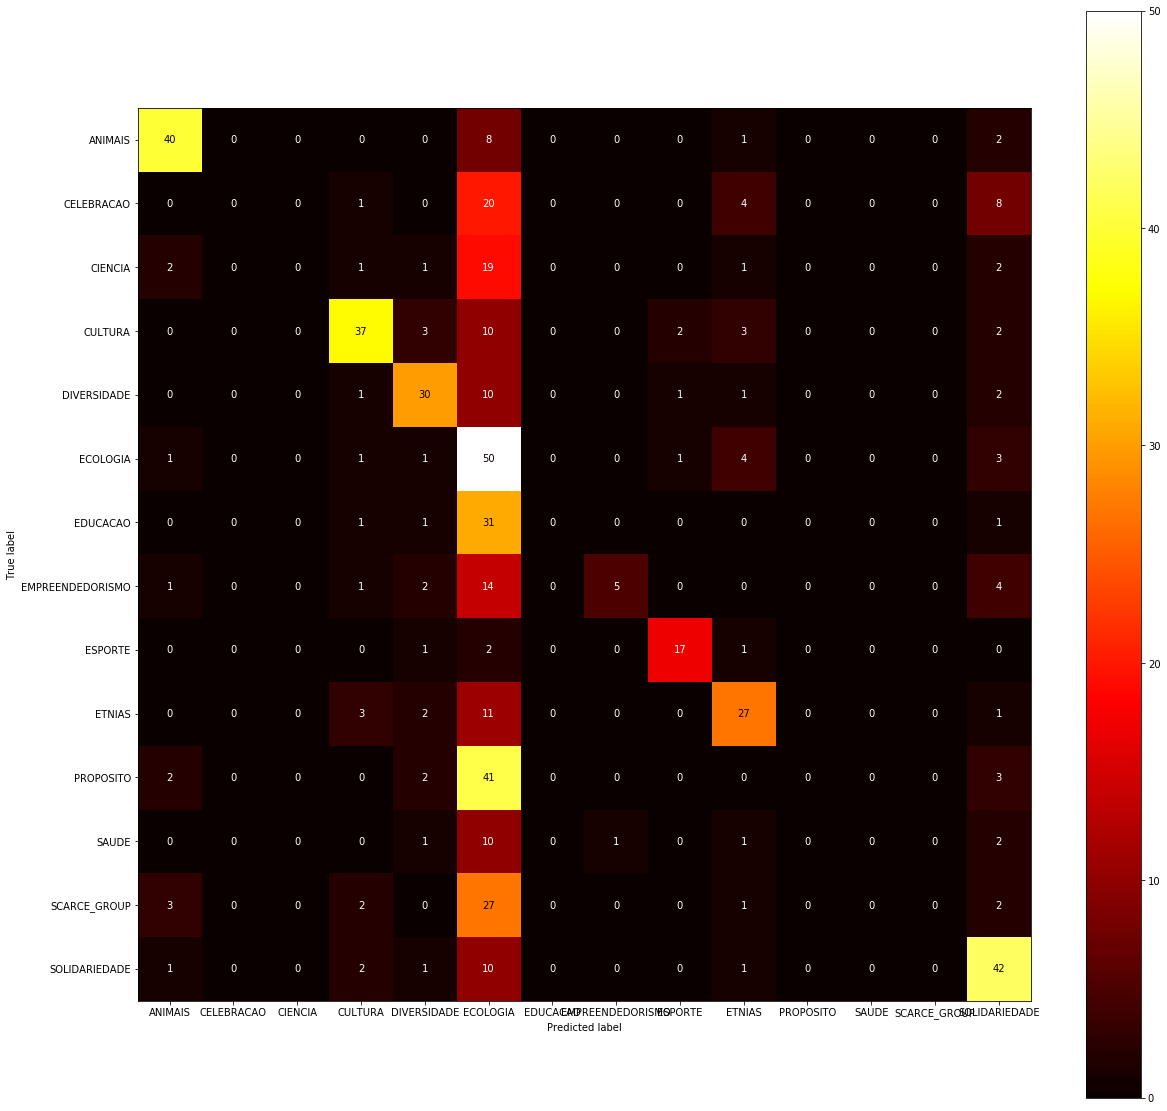

In [214]:
fig = plt.figure(figsize=(20, 20))
axes = plt.axes()

print(plot_confusion_matrix(pipeline, preds, labelsTest1, cmap='hot', ax=axes))